In [1]:
import torch
import torchvision
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')

  os.chdir('/content/drive/MyDrive/GitHub/kornia')
except Exception:   # Not run on Google Colab
  import getpass
  if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
  else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))

print(os.getcwd())
import sys
sys.path.insert(0, os.getcwd())

from kornia.nerf.camera_utils import parse_colmap_output, cameras_for_ids
from kornia.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt
import glob

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/kornia


## Load scene images and plot one of them

In [2]:
# scene_name = 'head_sculpture4'
scene_name = 'lego'
data_dir = 'kornia/nerf/kornia_nerf_data/'
# img_ext = 'jpeg'
img_ext = 'png'

scene_dir = os.path.join(data_dir, scene_name)


print(f'Scene directory: {scene_dir}, image extensions: {img_ext}')

Scene directory: kornia/nerf/kornia_nerf_data/lego, image extensions: png


torch.Size([4, 800, 800])
100


torch.Size([800, 800, 3])

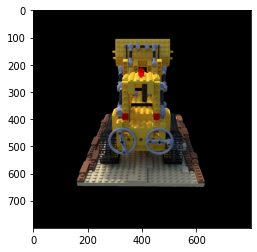

In [3]:
img_dir = os.path.join(scene_dir, 'images')

img_paths = sorted(glob.glob(f'{img_dir}/*.{img_ext}'))

img0 = read_image(img_paths[0])
print(img0.shape)

imgs: torch.tensor = []
camera_ids = []
num_cams_to_load = -1
for i, img_path in enumerate(img_paths):
    if num_cams_to_load != -1 and i == num_cams_to_load:
        break
    img = read_image(img_path)

    img = img[:3, ...]    # FIXME: This is a hack until I understand how to work with the alpha channel

    imgs.append(img)
    camera_ids.append(i)

print(len(imgs))
img_plt = torch.permute(imgs[0], (1, 2, 0))
plt.imshow(img_plt)
img_plt.shape

## Parse cameras from estimated pos xml

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

colmap_camera_model_path = os.path.join(scene_dir, 'cameras.txt')
colmap_images_model_path = os.path.join(scene_dir, 'images.txt')

img_names, cameras = parse_colmap_output(
    cameras_path=colmap_camera_model_path, 
    images_path=colmap_images_model_path, 
    device=device,
    dtype=torch.float32)

# To use same subset of cameras as input images
cameras = cameras_for_ids(cameras, camera_ids)

print(cameras.batch_size)
for i in range(cameras.batch_size):
  print(f'Intrinsics: \n{cameras.intrinsics[i]}; \nExtrinsics: \n{cameras.extrinsics[i]}')

cuda
100
Intrinsics: 
tensor([[1.0831e+03, 0.0000e+00, 4.0000e+02, 0.0000e+00],
        [0.0000e+00, 1.0831e+03, 4.0000e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.4991,  0.4868, -0.7169,  2.5417],
        [-0.2670,  0.8735,  0.4071, -2.5265],
        [ 0.8244, -0.0118,  0.5659,  2.7700],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[1.0989e+03, 0.0000e+00, 4.0000e+02, 0.0000e+00],
        [0.0000e+00, 1.0989e+03, 4.0000e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.4939, -0.4838,  0.7225, -2.8922],
        [ 0.1821,  0.8700,  0.4581, -2.8907],
        [-0.8502, -0.0947,  0.5178,  3.6730],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[1.0914e+0

### Downsample image and adjust intrinsics

In [5]:
downscale = 8.

if downscale > 1:
  height = int(imgs[0].shape[1] / downscale)
  width = int(imgs[0].shape[2] / downscale)
  transform = torchvision.transforms.Resize((height, width))

  for i, img in enumerate(imgs):
      img = transform(img)
      if img.shape[0] == 4: # Convert RGBA to RGB
        img = kornia.color.rgba_to_rgb(img / 255.)
        img = (img * 255.).to(torch.uint8)
      imgs[i] = img

  cameras = cameras.scale(1. / downscale)

  print(imgs[0].shape)

  print(cameras.batch_size)
  for i in range(cameras.batch_size):
    print(f'Intrinsics: \n{cameras.intrinsics[i]}; \nExtrinsics: \n{cameras.extrinsics[i]}')

torch.Size([3, 100, 100])
100
Intrinsics: 
tensor([[135.3891,   0.0000,  50.0000,   0.0000],
        [  0.0000, 135.3891,  50.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.4991,  0.4868, -0.7169,  2.5417],
        [-0.2670,  0.8735,  0.4071, -2.5265],
        [ 0.8244, -0.0118,  0.5659,  2.7700],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[137.3660,   0.0000,  50.0000,   0.0000],
        [  0.0000, 137.3660,  50.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.4939, -0.4838,  0.7225, -2.8922],
        [ 0.1821,  0.8700,  0.4581, -2.8907],
        [-0.8502, -0.0947,  0.5178,  3.6730],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[136.4211,   0.0000,  50.0000,   0.0000],
        [  

## Run training on image scene

In [7]:
nerf_obj = NerfSolver(device=device, dtype=torch.float32)
num_img_rays = 128
batch_size = 4096

nerf_obj.init_training(cameras=cameras, min_depth=2., max_depth=6., ndc=False, imgs=imgs, num_img_rays=num_img_rays, 
                       batch_size=batch_size, num_ray_points=256, irregular_ray_sampling=True)

# torch.manual_seed(0)    # For reproducibility of random processes

nerf_obj.run(num_epochs=10000)

RuntimeError: ignored

In [ ]:
# nerf_obj.run(num_epochs=10000)

## Rendering novel views

### Sub-set of input cameras

In [ ]:
from kornia.nerf.camera_utils import cameras_for_ids

camera_ids = [0]
cameras_to_render = cameras_for_ids(cameras, camera_ids)

In [ ]:
imgs_rendered = nerf_obj.render_views(cameras_to_render)

In [ ]:
plt.imshow(imgs_rendered[0])

### Spline path pattern

### Spiral pattern

In [ ]:
from kornia.nerf.camera_utils import create_spline_curve, create_spiral_path

cameras_spline_path = create_spline_curve(cameras, 60)

# cameras_spline_path = create_spiral_path(cameras, rad=1., num_views=60, num_circles=2)

imgs_rendered_spline_path = nerf_obj.render_views(cameras_spline_path)

In [ ]:
# nerf_obj._imgs = []
# imgs = []


In [ ]:
# from kornia.nerf.camera_utils import create_spiral_path

# cameras_spiral = create_spiral_path(cameras, rad=1., num_views=30, num_circles=2)
# imgs_rendered_spiral = nerf_obj.render_views(cameras_spiral)

### Create movie for output pattern

In [ ]:
import numpy as np
import imageio

imgs_rendered_spline_path_numpy = [img_rendered_spline_path.cpu().numpy() for img_rendered_spline_path in imgs_rendered_spline_path]

gif_path = os.path.join(scene_dir, scene_name + '_spline_path.gif')
imageio.mimwrite(gif_path, imgs_rendered_spline_path_numpy, fps=30)

In [ ]:
from IPython.display import Image
Image(open(gif_path, 'rb').read())